# Creating PV Diagrams
This notebook is for creating `position-velocity (PV)` diagrams of the reduced and calibrated ALMA data. 


In [1]:
path_to_beads = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [2]:
#system
from __future__ import division
import sys

#numpy
import numpy as np

#astropy
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import Angle
import astropy.constants as const
from astropy.coordinates import Galactic
from astropy.cosmology import LambdaCDM

#seaborn
import seaborn as sns

#matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import  Rectangle
from matplotlib import cm
%matplotlib inline

#pv extractor
from pvextractor import extract_pv_slice
from pvextractor import PathFromCenter

#spectral cube
from spectral_cube import SpectralCube

##ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
#import my own functions: you can see them in full in the utils folder
util_path = path_to_beads + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import science_functions as sf

In [4]:
#About
name = 'SDSS J1531+3414'
ra = 232.7936938
dec = 34.2404172
radius = Angle(2.5, u.arcsec)

zh  = 0.335 #z selected from Hennawi (2008)
cz = zh * const.c.to('km/s') 

cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73)

In [5]:
pf.styleplots()

In [6]:
file_path = 'Analysis/almaBeads/cannon/'
fig_path = path_to_beads + 'Figures/paper/'

co32_file = path_to_beads + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor.fits'
m0_name, m1_name, m2_name = co32_file[:-5]+ '_M0.fits', co32_file[:-5] + '_M1.fits', co32_file[:-5] + '_M2.fits'


### Create PV Diagrams

Define DS9 region covering the entire molecular structure

Total Region - box(54.6827002,55.1567183,3.163",5.320",65.491813)


In [8]:
#define path using ds9 region
g = Galactic(54.6827002 * u.deg, 55.1567183 * u.deg)
total_region_path = PathFromCenter(center=g, length=5.320 * u.arcsec, angle=65.491813 * u.deg,  width=3.163 * u.arcsec)

#print pixel coordinates of path
cube = SpectralCube.read(co32_file)
print(total_region_path.get_xy(wcs=cube.wcs))


[(149.16800244806907, 116.59441057737426), (171.82946470207474, 164.72650099932594)]


Cube is a Stokes cube, returning spectral cube for I component


In [9]:
#extract pv slice
total_region_slice = extract_pv_slice(cube, total_region_path)  

The following kwargs were not used by contour: 'rasterized'
findfont: Font family ['Computer Modern Roman'] not found. Falling back to DejaVu Sans.
savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6


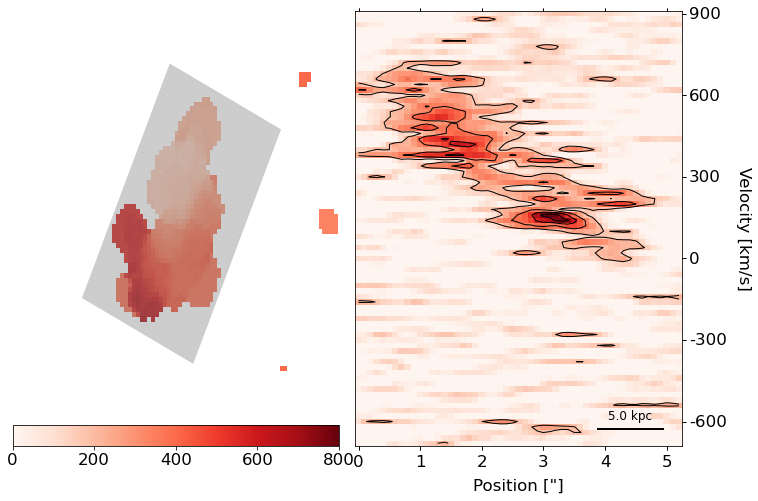

In [16]:
#Plot PV Diagram
fig = plt.figure(figsize=(12, 8))

hdu2, hdr2 = total_region_slice, total_region_slice.header
m1hdu, m1hdr, m1wcs = pf.open_fits(m1_name)
hdu3, hdr3 =  m1hdu, m1hdr

cmap = cm.Reds
            
gs1 = GridSpec(1, 2)
gs1.update(wspace=0.05, hspace=0.01)

radius = Angle(2.5, u.arcsec)
mom_coords = [ra+ 1e-4, dec-4e-4, radius*1.7]

ax3 = fig.add_subplot(gs1[0, 0], projection=WCS(hdr3))
ax3 = pf.ax_fits_map(hdu3, vmin=0, vmax=800, cmap=cmap, 
                     coords=mom_coords, ax=ax3, contour=False, 
                     nlevels=40, clip=None, lw=5, location='bottom', factor=1e3)
pf.hide_plot_labels(ax3, hdr3)

patches = [total_region_path.to_patches(1, wcs=cube.wcs)]
for path in patches:
    for p in path:
        p.set_facecolor('grey')
        p.set_alpha(0.4)
        ax3.add_patch(p)

ax2 = fig.add_subplot(gs1[0, 1], projection=WCS(hdr2))
ax2 = pf.ax_fits_map(hdu2, cmap=cmap, ax=ax2, contour=False, vmin=0, vmax=None, cbar=False, nlevels=20)
pf.overlay(ax2, hdu2, 1, vmin=1.4e-4, vmax=1e-3, contours=True, cont_color='k', lw=1)
pf.add_scale(ax2, 5 * u.kpc, hdr2, cosmo, color='k', hdr_cdelt='CDELT1', ytxt=0.03, lw=2)

ycoord = ax2.coords[1]
ycoord.set_ticks(spacing=300 * (u.km/u.s))
ycoord.set_format_unit(u.km / u.s)
ycoord.set_axislabel('Velocity [km/s]')
loc='r'
ycoord.set_ticks_position('{}'.format(loc))
ycoord.set_ticklabel_position('{}'.format(loc))
ycoord.set_axislabel_position('{}'.format(loc))

xcoord = ax2.coords[0]
xcoord.set_ticks(number=5)
xcoord.set_major_formatter('x')
xcoord.set_format_unit(u.arcsec)
xcoord.set_axislabel('Position ["]')


fig.savefig(fig_path + "alma_m1_pv.pdf", optimize=True)
